In [15]:
from IPython import display
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf
from experiment_logger import (
    create_modquad_experiment_logger,
    log_modquad_experiment_params,
    log_modquad_environment_info,
    log_modquad_model_info,
    log_modquad_agent_info
)

import modquad_copp_env as modquad_env
import meta_learning_base as mlb
# import mbrl.env.reward_fns as reward_fns
# import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util
import modquad_utils 
import time
from models import modquad_ModelEnv
# import models. as mq_model


%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

seed = 0
env = modquad_env.ModQuadEnv()
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Connecting to CoppeliaSim...
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?


Get initial replay buffer. Either run simulation now or load existing flight data

In [16]:
#to test if gym environment simulation is working
import pickle

# replay_buffer_sim = env.run_gym_simulation_and_collect_data(cut_at = 300)
# with open('540_sim_data.pkl', 'wb') as f:
#     pickle.dump(replay_buffer_sim, f)

with open('300_del_sim_data.pkl', 'rb') as f:
    replay_buffer_sim = pickle.load(f)
    
# env.end_simulation()
# env.reset()

In [17]:

replay_buffer_sim
all_actions = []
for transition in replay_buffer_sim:
    obs, action, next_obs, reward, terminate, truncated = transition
    all_actions.append(action)

all_actions = np.array(all_actions)
print(all_actions.shape)

means = np.mean(all_actions, axis=0)
variances = np.var(all_actions, axis=0)
std_devs = np.std(all_actions, axis=0)
mins = np.min(all_actions, axis=0)
maxs = np.max(all_actions, axis=0)

print("Means:", means)
print("Variances:", variances)
print("Standard Deviations:", std_devs)
print("Minimums:", mins)
print("Maximums:", maxs)


(15265, 4)
Means: [ 3.23949864e+00  5.36027564e-04 -4.84867971e-04  6.32614510e-02]
Variances: [6.20798376e-03 1.65049139e-04 5.47030526e-05 7.42734344e-02]
Standard Deviations: [0.07879076 0.01284715 0.00739615 0.27253153]
Minimums: [-2.97410935 -0.03208319 -0.02861625 -0.37298277]
Maximums: [3.32384662 0.04769264 0.02794104 0.41069041]


In [21]:
trial_length = 200
num_trials = 20
ensemble_size = 5

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": "???",
        "out_size": "???",
        "deterministic": False,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "dataset_size": 10000,
        "learned_rewards": False,
        "target_is_delta": True,
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 64,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)

# Create a gym-like environment to encapsulate the model
model_env = modquad_ModelEnv.modquad_ModelEnv(env, dynamics_model, generator=generator)

replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

for tr in replay_buffer_sim:
    obs, action, next_obs, reward, terminate, truncated = tr
    replay_buffer.add(obs, action, next_obs, reward, terminate, truncated)
print("# samples stored", replay_buffer.num_stored)

agent_cfg = omegaconf.OmegaConf.create({
    # this class evaluates many trajectories and picks the best one
    "_target_": "mbrl.planning.TrajectoryOptimizerAgent",
    "planning_horizon": 15,#was 15 initially
    "replan_freq": 1,
    "verbose": False,
    "action_lb": "???",
    "action_ub": "???",
    # this is the optimizer to generate and choose a trajectory
    "optimizer_cfg": {
        "_target_": "mbrl.planning.CEMOptimizer",
        "num_iterations": 5,
        "elite_ratio": 0.1,
        "population_size": 50,
        "alpha": 0.1,
        "device": device,
        "lower_bound": "???",
        "upper_bound": "???",
        "return_mean_elites": True,
        "clipped_normal": False
    }
})

agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)


# samples stored 10000


Main experiment block 

In [22]:
env.end_simulation()
env.reset()

Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?


(array([ 5.5931177e-04,  2.9986379e-01,  9.9368937e-02, -1.6290265e-04,
        -1.3953269e-05,  6.5769593e-04, -4.0627341e-08, -1.1241756e-08,
        -1.5859010e-08, -5.8620262e-08, -3.7064276e-09,  2.0069589e-07],
       dtype=float32),
 {})

[ 0. 12. 24. 36. 48. 60.]
[ 0.    6.25 12.5  18.75 25.  ]
resetting environment, and starting trial : 0
Connected!
4 DoF [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
No propeller. Is it a magic box?
setpoint updated
setting setpoint to:  0.0 0.0 1.0150579389358555e-05
Number of stored transitions:  10000
Training model
training loss:  -46.84023914721188
validation loss:  2.569879507063888e-05
training time:  53.09490656852722
Model trained
planning for trajectory step:  1
action:  [ 0.21749908 -0.01546363  0.02756165 -0.1494132 ] reward:  -0.3159000012351086
planning time:  0.26010870933532715
setpoint updated
setting setpoint to:  0.0 0.0 7.997055280231069e-05
planning for trajectory step:  2
action:  [0.27216193 0.02757093 0.03236715 0.2313004 ] reward:  -0.31590075885479907
planning time:  0.24824094772338867
setpoint updated
setting setpoint to:  0.0 0.0 0.00026576965766001126
planning for trajectory step:  3
action:  [0.18656877 0.00741927 0.01164526 0.19582385] reward:  -0.31590263263494

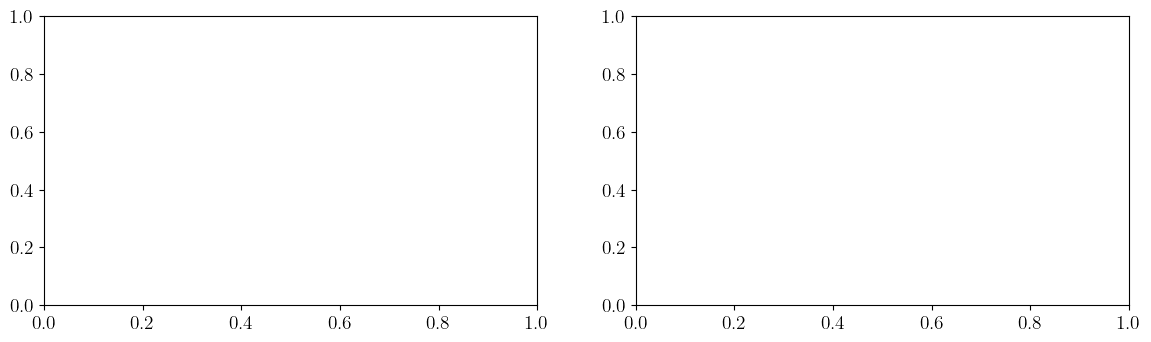

In [23]:
train_losses = []
val_scores = []
train_time = []
plan_time = []

def train_callback(_model, _total_calls, _epoch, tr_loss, val_score, _best_val):
    train_losses.append(tr_loss)
    val_scores.append(val_score.mean().item())   # this returns val score per ensemble model


# Create a trainer for the model
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=5e-5, weight_decay=5e-5)
env.initialize_target_trajectory(traj = "random trajectory", num_waypoints=3) 
# Create visualization objects
fig, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
ax_text = axs[0].text(300, 50, "")
    
# the states will encapsulate the desired trajectory \

# Main PETS loop
all_rewards = [0]
trajectory_length, total_time, pos_traj, orient_traj = env.initialize_target_trajectory(traj = "random trajectory", std_position_change=0.5, num_waypoints=3, num_hover_points=2, time_step_duration=5)
#     trajectory parameters, default arguments used for random trajectory
#     start_pos=[0.0, 0.0, 1.0], start_yaw=0.0, 
#     start_vel=[0.0, 0.0, 0.0], start_yaw_rate=0.0,
#     std_position_change=0.2,
#     std_orientation_change=0.1,
#     std_velocity_change=0.05,
#     std_angular_velocity_change=0.0,
#     std_acceleration_change=0.0,
#     std_angular_acceleration_change=0.0,
#     num_waypoints=20, 
#     num_hover_points=3,
#     time_step_duration=10

model_env.set_desired_trajectory(total_time, pos_traj, orient_traj)
model_env.trajectory_step = 0
# logger._write_to_log("\nStarting main experiment loop...")

for trial in range(num_trials):
    
    print("resetting environment, and starting trial :", trial)
    obs, _ = env.reset()    
    agent.reset()
    
    terminated = False
    truncated = False
    total_reward = 0.0
    steps_trial = 0

    traj_step = 0 
    model_env.trajectory_step = 0
    env.trajectory_step = 0
    last_setpoint_set = time.time()
    time.sleep(0.5)
    # env.pause_simulation()

    # update_axes(axs, env.render(), ax_text, trial, steps_trial, all_rewards)
    while not (terminated or truncated or (model_env.trajectory_step >= trajectory_length-1)):

        if (time.time() - last_setpoint_set > total_time/trajectory_length) :
            # env.resume_simulation()
            model_env.trajectory_step += 1
            last_setpoint_set = time.time()
            print("setpoint updated")
            env.update_setpoint(model_env.trajectory_step)
            
            

            # env.pause_simulation()

        
        # --------------- Model Training -----------------
        if steps_trial == 0:
            print("Number of stored transitions: ", replay_buffer.num_stored)
            dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats
            
            dataset_train, dataset_val = common_util.get_basic_buffer_iterators(
                replay_buffer,
                batch_size=cfg.overrides.model_batch_size,
                val_ratio=cfg.overrides.validation_ratio,
                ensemble_size=ensemble_size,
                shuffle_each_epoch=True,
                bootstrap_permutes=False,  # build bootstrap dataset using sampling with replacement 
            )
            print("Training model")
            training_start_time = time.time()
            model_trainer.train(
                dataset_train, 
                dataset_val=dataset_val, 
                num_epochs=50, 
                patience=50, 
                callback=train_callback,
                silent=True)
            print("training loss: ", train_losses[-1])
            print("validation loss: ", val_scores[-1])
            print("training time: ", time.time() - training_start_time)
            print("Model trained")

        # --- Doing env step using the agent and adding to model dataset ---
        print("planning for trajectory step: ", model_env.trajectory_step)
        planning_start_time = time.time()
        next_obs, reward, terminated, truncated, _ = common_util.step_env_and_add_to_buffer(
            env, obs, agent, {}, replay_buffer)
        print("planning time: ", time.time() - planning_start_time)
        
            
        # update_axes(
        #     axs, env.render(), ax_text, trial, steps_trial, all_rewards)
        
        obs = next_obs
        total_reward += reward
        steps_trial += 1

    env.end_simulation()
        
    # if steps_trial == trial_length:
    #         break
    
    all_rewards.append(total_reward)

# update_axes(axs, env.render(), ax_text, trial, steps_trial, all_rewards, force_update=True)


In [24]:
print(all_rewards)

[0, -61.43014625271793, -39.3959555937571, -10.05214803830876, -10.231261296408805, -4.559030443513064, -15.945444964017872, -33.51818468697467, -9.854794340326542, -67.55281007049238, -56.59064877946464, -4.86295869128979, -9.372479357226307, -22.566700157247617, -24.073583247858597, -23.98017983061252, -40.56704539805338, -14.582135243021535, -6.048359377357873, -3.714329663714123, -14.064610929510014]
